In [ ]:
# import os
# import time
# import itertools

# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# import torch
# from torch import nn, optim
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# import torch.nn.functional as F
# from torch.utils.data import DataLoader
# from torch.utils.data.dataset import Subset
# import torchvision
# from torchvision import datasets, transforms
# from torchvision.transforms import Compose, ToTensor, Normalize
# from torchvision.datasets import MNIST

In [2]:
from scripts.utils import *
from scripts.tensorboard import *
from scripts.dataloaders import *
from scripts.trainers import *

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(64*6*6,600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(-1,64*6*6)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return F.log_softmax(x,dim=1)

In [4]:
params = {
    'train_batch_size': 64,
    'val_batch_size': 64,
    'epochs': 2,
    'lr': 1e-3,
    'verbose': True,
    'tensorboard': False,
    'log_interval': 100,
    'log_dir': './tensorboard_logs',
    'model_name': 'LeNet',
    'model': CNN(),
    'criterion': nn.NLLLoss(),
    'optimizer': optim.Adam,
    'early_stopping': True,
    'early_stopping_patience': 11,
    'lr_patience': 5,
    'lr_factor': 0.25,
    'min_lr': 1e-5,
    
}

In [5]:
%%time
model, optimizer, scheduler, stats = train(params, get_MNIST_data_loaders)

Device:  cpu
Epoch[1] Iteration[100/938] Loss: 0.74
Epoch[1] Iteration[200/938] Loss: 0.44
Epoch[1] Iteration[300/938] Loss: 0.39
Epoch[1] Iteration[400/938] Loss: 0.49
Epoch[1] Iteration[500/938] Loss: 0.41
Epoch[1] Iteration[600/938] Loss: 0.29
Epoch[1] Iteration[700/938] Loss: 0.37
Epoch[1] Iteration[800/938] Loss: 0.25
Epoch[1] Iteration[900/938] Loss: 0.41
Training Results - Epoch: 1  Avg accuracy: 0.90 Avg loss: 0.28
Validation Results - Epoch: 1  Accuracy: 0.90  loss: 0.28
Epoch[2] Iteration[1000/938] Loss: 0.17
Epoch[2] Iteration[1100/938] Loss: 0.30
Epoch[2] Iteration[1200/938] Loss: 0.30
Epoch[2] Iteration[1300/938] Loss: 0.27
Epoch[2] Iteration[1400/938] Loss: 0.29
Epoch[2] Iteration[1500/938] Loss: 0.39
Epoch[2] Iteration[1600/938] Loss: 0.18
Epoch[2] Iteration[1700/938] Loss: 0.37
Epoch[2] Iteration[1800/938] Loss: 0.30
Training Results - Epoch: 2  Avg accuracy: 0.91 Avg loss: 0.25
Validation Results - Epoch: 2  Accuracy: 0.91  loss: 0.25
Final accuracy:  0.9126
Confusion 

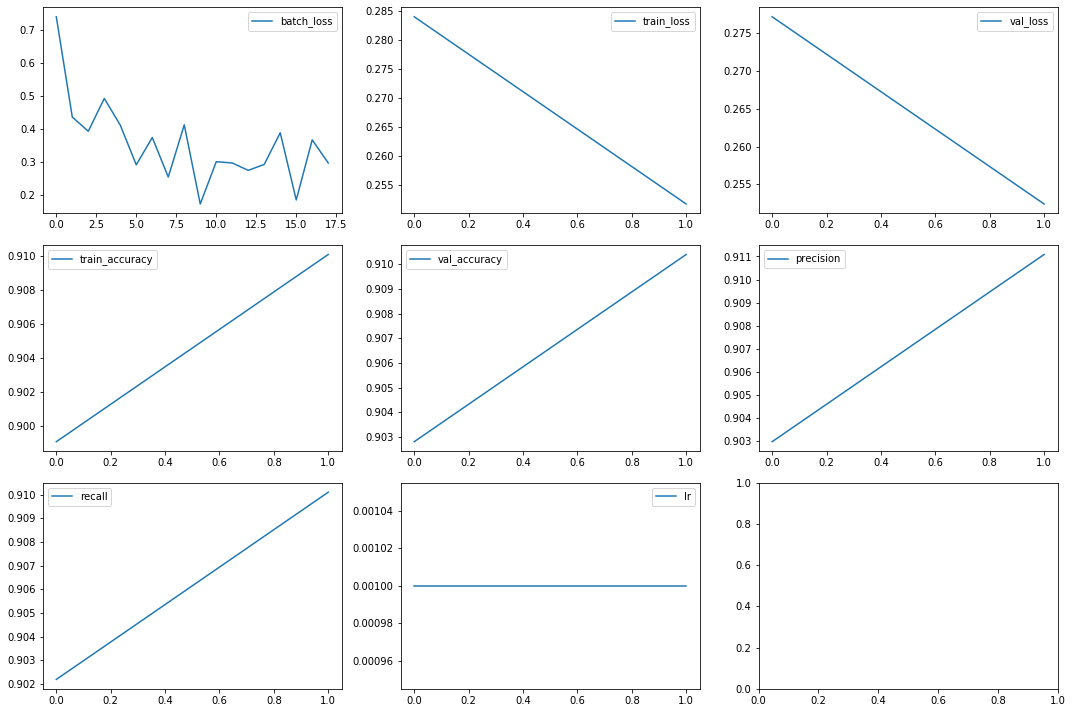

tensor([[424,   1,   0,   4,   1,   0,  25,   0,   0,   0],
        [  1, 509,   0,   6,   1,   0,   1,   0,   0,   0],
        [ 10,   0, 409,   3,  31,   0,  34,   0,   0,   0],
        [ 23,   2,   4, 462,   3,   0,  20,   0,   0,   0],
        [  3,   1,  21,  16, 426,   0,  23,   0,   0,   0],
        [  0,   0,   0,   0,   0, 473,   0,   2,   0,   1],
        [104,   2,  24,   6,  24,   0, 395,   0,   2,   0],
        [  0,   0,   0,   0,   0,   6,   0, 499,   0,   7],
        [  3,   1,   0,   4,   0,   2,   4,   1, 479,   0],
        [  0,   0,   0,   0,   0,   2,   0,   8,   0, 487]])


In [6]:
plot_stats(stats)

In [7]:
%%time
model, optimizer, scheduler, stats = continue_training(model, params, get_MNIST_data_loaders, stats, scheduler, optimizer, 
                  new_params={
                      'epochs': 2,
                  })

Device:  cpu
Epoch[1] Iteration[100/938] Loss: 0.31
Epoch[1] Iteration[200/938] Loss: 0.11
Epoch[1] Iteration[300/938] Loss: 0.27
Epoch[1] Iteration[400/938] Loss: 0.40
Epoch[1] Iteration[500/938] Loss: 0.26
Epoch[1] Iteration[600/938] Loss: 0.18
Epoch[1] Iteration[700/938] Loss: 0.25
Epoch[1] Iteration[800/938] Loss: 0.25
Epoch[1] Iteration[900/938] Loss: 0.19
Training Results - Epoch: 1  Avg accuracy: 0.92 Avg loss: 0.22
Validation Results - Epoch: 1  Accuracy: 0.92  loss: 0.22
Epoch[2] Iteration[1000/938] Loss: 0.09
Epoch[2] Iteration[1100/938] Loss: 0.25
Epoch[2] Iteration[1200/938] Loss: 0.23
Epoch[2] Iteration[1300/938] Loss: 0.24
Epoch[2] Iteration[1400/938] Loss: 0.23
Epoch[2] Iteration[1500/938] Loss: 0.32
Epoch[2] Iteration[1600/938] Loss: 0.22
Epoch[2] Iteration[1700/938] Loss: 0.31
Epoch[2] Iteration[1800/938] Loss: 0.27
Training Results - Epoch: 2  Avg accuracy: 0.91 Avg loss: 0.23
Validation Results - Epoch: 2  Accuracy: 0.91  loss: 0.23
Final accuracy:  0.9154
Confusion 

TypeError: cannot unpack non-iterable NoneType object

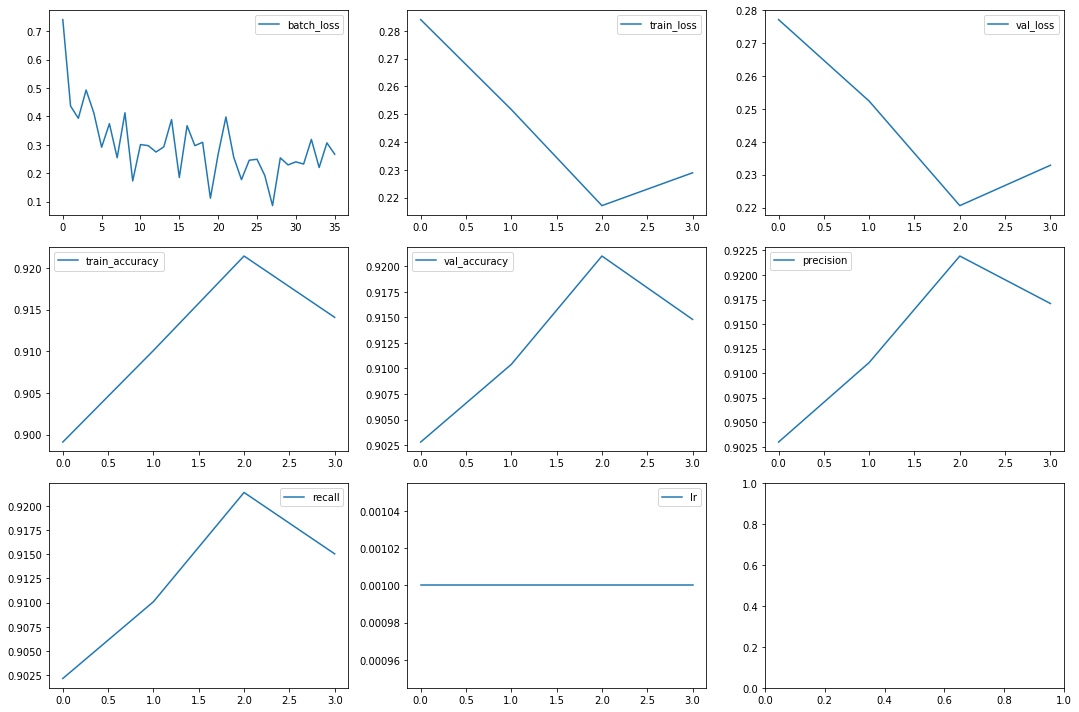

tensor([[431,   0,   0,   0,   2,   0,  42,   0,   0,   0],
        [  1, 508,   0,   3,   0,   0,   0,   0,   0,   0],
        [ 10,   0, 443,   2,  12,   0,  41,   0,   0,   0],
        [ 23,   3,   3, 434,   4,   0,  28,   0,   1,   0],
        [  0,   0,  37,  12, 422,   0,  28,   0,   0,   0],
        [  0,   0,   0,   0,   0, 501,   0,   0,   0,   1],
        [ 55,   0,  18,   4,  17,   0, 401,   0,   0,   0],
        [  0,   0,   0,   0,   1,  18,   0, 462,   0,  36],
        [  0,   0,   2,   0,   2,   0,  10,   0, 484,   0],
        [  0,   0,   0,   0,   0,   5,   0,   0,   2, 491]])


In [8]:
plot_stats(stats)

In [9]:
# model = CNN()
# model.load_state_dict(torch.load('./tensorboard_logs/MNIST/saved_models/MNIST_LeNet_lr:0.001_Adam_NLLLoss_37520.pth'))